In [1]:
import json
import os
import pickle
import sys
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd

with open('../dirs.json', 'r') as f:
    dirs = json.load(f)
sys.path.append(dirs['root'])

from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import StandardScaler

from utils.ipm import NeuronLoader
from utils.metrics import DescriminationConfidenceEstimator as DCE
from utils.utils import mkeqdata
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import kendalltau
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.ndimage import gaussian_filter1d as smooth

nmb_rep = 100

outPath = os.path.join(dirs['out']['rsa'])
os.makedirs(outPath, exist_ok=True)

In [2]:
monkey = "both"
selectivity = "fast"

# grangerInfluence = {'itc2pfc': {}, 'pfc2itc': {}}
grangerInfluence = {}
with open("../utils/info.pkl", "rb") as handler:
    info = pickle.load(handler)
info = info[:165]
sIndex = ((info.sfr == "A") | (info.sfr == "BI"))
noneIndex = (info.cat == "none")
info = info[~noneIndex & sIndex].reset_index(drop=True)
itc = np.load(f"G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}/ITCNoAvg.npy")
pfc = np.load(f"G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}/PFCNoAvg.npy")
itc = itc[~noneIndex & sIndex]
pfc = pfc[~noneIndex & sIndex]

In [3]:
from sklearn.feature_selection import mutual_info_regression as minf
def movavg(inp, bl, ss):
    nbin = int(np.floor((inp.shape[2] - bl) / ss))
    out = np.nan * np.zeros((inp.shape[0], inp.shape[1], nbin))
    for ibin in range(nbin):
        out[:, :, ibin] = np.sum(inp[:, :, int(ibin*ss):int(ibin*ss)+bl], 2) / bl * 1000
    return out

In [6]:
bl, ss = 50, 5
itcData = movavg(itc, bl, ss)
pfcData = movavg(pfc, bl, ss)

In [ ]:
mi = {}
for s, category in zip([info.fac, info.bod, info.art, info.nat], ["face", "body", "artificial", "natural"]):
    _mi = []
    for neuron in tqdm(range(itcData.shape[1])):
        r = itcData[:, neuron, :]
        
        __mi = []
        for time in range(itcData.shape[2]):
            __mi.append(minf(r[:, time].reshape(-1, 1), s, random_state=0))
        _mi.append(__mi)
    mi[category] = np.array(_mi).squeeze()

with open(os.path.join(dirs['out']['inf'], 'itc-per-category.pickle'), 'wb') as handle:
    pickle.dump(mi, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
mi = {}
for s, category in zip([info.fac, info.bod, info.art, info.nat], ["face", "body", "artificial", "natural"]):
    _mi = []
    for neuron in tqdm(range(pfcData.shape[1])):
        r = pfcData[:, neuron, :]
        
        __mi = []
        for time in range(pfcData.shape[2]):
            __mi.append(minf(r[:, time].reshape(-1, 1), s, random_state=0))
        _mi.append(__mi)
    print(f"{category}: finished")
    mi[category] = np.array(_mi).squeeze()

with open(os.path.join(dirs['out']['inf'], 'pfc-per-category.pickle'), 'wb') as handle:
    pickle.dump(mi, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
with open(os.path.join(dirs['out']['inf'], 'itc-per-category.pickle'), 'rb') as handle:
    itc = pickle.load(handle)
with open(os.path.join(dirs['out']['inf'], 'pfc-per-category.pickle'), 'rb') as handle:
    pfc = pickle.load(handle)

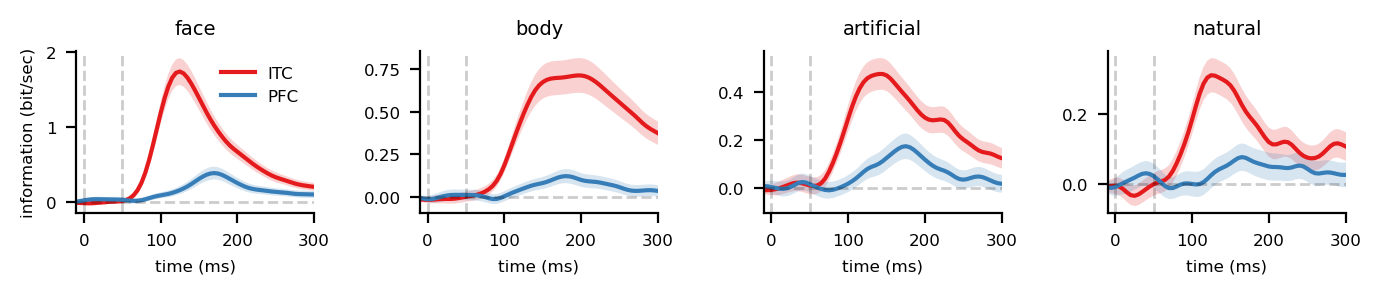

In [44]:
tim = np.arange(-200, 650, step=5) + 25
sns.set_palette('Set1')

cm = 1 / 2.54
fig, axs = plt.subplots(1, 4, figsize=(18 * cm, 4 * cm), dpi=200, sharey=False)

for ax, category in zip(axs.flat, pfc.keys()):
    
    for region_name, region in zip(['ITC', 'PFC'], [itc, pfc]):
        X = region[category] / 50 * 1000
        X = smooth(X, sigma=2)
        X -= X[:, (tim > -50) & (tim < 0)].mean(1).reshape(-1, 1)
        ax.plot(tim, X.mean(0), label=region_name)
        ax.fill_between(tim, \
            X.mean(0) + 1.96 / np.sqrt(X.shape[0]) * X.std(0), \
            X.mean(0) - 1.96 / np.sqrt(X.shape[0]) * X.std(0), \
            alpha=.2, label='_nolegend_')
        ax.set_title(category, fontsize=7)

for ax in axs.flat:
    ax.axvline(0, color='k', ls='dashed', lw=1, alpha=.2, label='_nolegend_')
    ax.axvline(50, color='k', ls='dashed', lw=1, alpha=.2, label='_nolegend_')
    ax.set_xlim(-10, 300)
    ax.set_xlabel('time (ms)', fontsize=6)
    ax.set_ylabel('')
    ax.axhline(0, color='k', ls='--', lw=1, alpha=.2, label='_nolegend_')
    ax.tick_params(axis='both', which='major', labelsize=6)

axs[0].legend(frameon=False, fontsize=6)
axs[0].set_ylabel('information (bit/sec)', fontsize=6)

sns.despine()
fig.tight_layout()

plt.savefig('information.pdf')

In [119]:
maxinfo, category, region = [], [], []
for reg, reg_name in zip([itc, pfc], ['ITC', 'PFC']):
    for cat in itc.keys():
        X = smooth(reg[cat], sigma=2.5)
        X = X[:, (tim > 0) & (tim <= 250)] - X[:, (tim < 0) & (tim >= -100)].mean(1).reshape(-1, 1)
        maxinfo.extend(X.max(1))
        category.extend(np.full(X.shape[0], fill_value=cat, dtype=object))
        region.extend(np.full(X.shape[0], fill_value=reg_name, dtype=object))

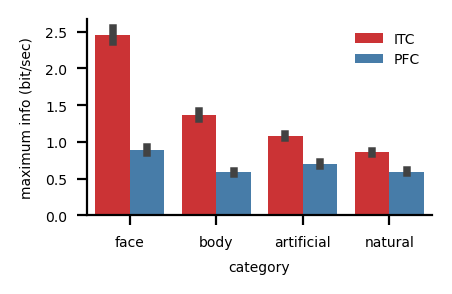

In [120]:
cm = 1 / 2.54
fig, ax = plt.subplots(1, 1, figsize=(6 * cm, 4 * cm), dpi=200, sharey=False)

df = pd.DataFrame({'maxinfo': np.array(maxinfo) / 50 * 1000, 'category': category, 'region': region})
g = sns.barplot(x='category', y='maxinfo', hue='region', ci=68, data=df, ax=ax)

ax.legend(frameon=False, fontsize=5)
ax.tick_params(axis='both', which='major', labelsize=5)
# ax.set_title('Maximum Information', fontsize=7)
ax.set_xlabel('category', fontsize=5)
ax.set_ylabel('maximum info (bit/sec)', fontsize=5)

sns.despine()
fig.tight_layout()

In [ ]:
maxinfo, category, region = [], [], []
for reg, reg_name in zip([itc, pfc], ['ITC', 'PFC']):
    for cat in itc.keys():
        X = smooth(reg[cat], sigma=2.5)
        X = X[:, (tim > 0) & (tim <= 250)] - X[:, (tim < 0) & (tim >= -100)].mean(1).reshape(-1, 1)
        maxinfo.extend(X.max(1))
        category.extend(np.full(X.shape[0], fill_value=cat, dtype=object))
        region.extend(np.full(X.shape[0], fill_value=reg_name, dtype=object))

In [ ]:
maxinfo, category, region = [], [], []
for reg, reg_name in zip([itc, pfc], ['ITC', 'PFC']):
    for cat in itc.keys():
        X = smooth(reg[cat], sigma=2.5)
        X = X[:, (tim > 0) & (tim <= 250)] - X[:, (tim < 0) & (tim >= -50)].mean(1).reshape(-1, 1)
        maxinfo.extend(X.max(1))
        category.extend(np.full(X.shape[0], fill_value=cat, dtype=object))
        region.extend(np.full(X.shape[0], fill_value=reg_name, dtype=object))

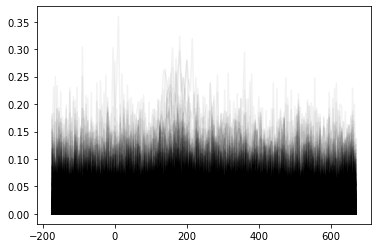

In [127]:
plt.plot(tim, pfc['artificial'].T, color='k', alpha=.05);